<a href="https://colab.research.google.com/github/kommurisi/Individual_SiddiKommuri_HandlingMissingData-Titanic/blob/main/Siddi_GenAI_WorkedExamples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Generation — Worked Examples (Dataset Pair: OpenWebText + Gutenberg)

We fine-tune a small causal language model (`distilgpt2`) on two corpora and compare **perplexity** and sample quality.  
All steps include: data loading, preprocessing, model setup, training, evaluation, simple visualizations, and brief discussion.


In [1]:
# Setup (dependencies + imports)
!pip -q install transformers datasets accelerate

import math, os, json, random, numpy as np, matplotlib.pyplot as plt
import torch
from datasets import load_dataset, Dataset
from transformers import (AutoTokenizer, AutoModelForCausalLM,
                          DataCollatorForLanguageModeling, Trainer, TrainingArguments, set_seed)
set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


## 1. Title & Introduction

**Topic:** Text Generation with tiny GPT-2 (distilgpt2).  
**Approach:** Minimal fine-tuning on (A) OpenWebText sample and (B) Gutenberg books; evaluate with **perplexity** and short generations.  
**Why these datasets?** They represent different domains (web vs. literary prose) to highlight domain effects on language modeling.


## 2. First Worked Example — Dataset A (Primary)

**Task:** Fine-tune a small causal LM (`distilgpt2`) on a compact web-style corpus and evaluate **perplexity** + sample text.  
We follow the required sub-sections: *Data preprocessing → Model architecture → Training procedure → Evaluation metrics → Results visualization → Discussion & limitations.*


In [9]:
# A1) Load + split (primary dataset proxy for OpenWebText)
from datasets import load_dataset, Dataset

TARGET_N = 4000  # small slice for fast Colab runs
raw = load_dataset("wikitext", "wikitext-2-raw-v1")
texts = [t for split in ("train","validation") for t in raw[split]["text"] if t and t.strip()]
texts = texts[:TARGET_N]
owt = Dataset.from_dict({"text": texts}).train_test_split(test_size=0.05, seed=42)
print(owt)


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 3800
    })
    test: Dataset({
        features: ['text'],
        num_rows: 200
    })
})


In [10]:
# A2) Tokenization (fixed block size; causal labels = input_ids)
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
tok = AutoTokenizer.from_pretrained("distilgpt2")
tok.pad_token = tok.eos_token
BLOCK = 128

def pack(ex):
    out = tok(ex["text"], truncation=True, padding="max_length", max_length=BLOCK)
    out["labels"] = out["input_ids"].copy()
    return out

owt_tok = owt.map(pack, batched=True, remove_columns=["text"])
collator = DataCollatorForLanguageModeling(tok, mlm=False)
len(owt_tok["train"]), len(owt_tok["test"])


Map:   0%|          | 0/3800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

(3800, 200)

In [11]:
# A3) Tiny GPT-2 (distilgpt2); autoregressive LM head with cross-entropy loss
import torch
from transformers import AutoModelForCausalLM
device = "cuda" if torch.cuda.is_available() else "cpu"

mA = AutoModelForCausalLM.from_pretrained("distilgpt2")
mA.resize_token_embeddings(len(tok))   # ensure EOS-as-PAD works
mA = mA.to(device)
mA.config.n_positions, mA.config.n_ctx  # context length (for info)


(1024, 1024)

In [13]:
import os
# turn off 3rd-party logging integrations
os.environ["WANDB_DISABLED"] = "true"        # disable wandb
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1" # optional: disable HF telemetry
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # quiet tokenizer warnings


In [15]:
from datasets import load_dataset, Dataset

raw = load_dataset("wikitext", "wikitext-2-raw-v1")
texts = [t for split in ("train","validation") for t in raw[split]["text"] if t and t.strip()]
texts = texts[:TARGET_N]
owt = Dataset.from_dict({"text": texts}).train_test_split(test_size=0.05, seed=42)
print(owt)


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 3800
    })
    test: Dataset({
        features: ['text'],
        num_rows: 200
    })
})


In [17]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
tok = AutoTokenizer.from_pretrained("distilgpt2")
tok.pad_token = tok.eos_token

def pack(ex):
    out = tok(ex["text"], truncation=True, padding="max_length", max_length=BLOCK)
    out["labels"] = out["input_ids"].copy()
    return out

owt_tok = owt.map(pack, batched=True, num_proc=2, remove_columns=["text"])
collator = DataCollatorForLanguageModeling(tok, mlm=False)

# take tiny train/val slices
n_train = min(2000, len(owt_tok["train"]))
n_val   = min(200,  len(owt_tok["test"]))
trainA  = owt_tok["train"].select(range(n_train))
valA    = owt_tok["test"].select(range(n_val))
len(trainA), len(valA)


Map (num_proc=2):   0%|          | 0/3800 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/200 [00:00<?, ? examples/s]

(2000, 200)

In [23]:
# A0) Setup: install + imports + fast knobs
!pip -q install transformers datasets accelerate

import os, math, matplotlib.pyplot as plt, torch
from datasets import load_dataset, Dataset
from transformers import (AutoTokenizer, AutoModelForCausalLM,
                          DataCollatorForLanguageModeling, Trainer, TrainingArguments)

# make notebook quiet & simple
os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ultra-fast knobs
MODEL_ID  = "sshleifer/tiny-gpt2"  # very small GPT-2
N_TEXTS   = 200                    # tiny slice of text
BLOCK     = 64                     # short context
MAX_STEPS = 10                     # only 10 optimizer steps
BATCH     = 8                      # drop to 4 if CPU-only OOM

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [24]:
# A1) Load a tiny slice + split
raw = load_dataset("wikitext", "wikitext-2-raw-v1")
texts = [t for split in ("train","validation") for t in raw[split]["text"] if t and t.strip()][:N_TEXTS]
ds = Dataset.from_dict({"text": texts}).train_test_split(test_size=0.1, seed=42)
ds


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 180
    })
    test: Dataset({
        features: ['text'],
        num_rows: 20
    })
})

In [25]:
# A2) Tokenize and create LM labels (labels = input_ids for causal LM)
tok = AutoTokenizer.from_pretrained(MODEL_ID)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

def pack(ex):
    out = tok(ex["text"], truncation=True, padding="max_length", max_length=BLOCK)
    out["labels"] = out["input_ids"].copy()
    return out

tok_ds = ds.map(pack, batched=True, remove_columns=["text"])
collator = DataCollatorForLanguageModeling(tok, mlm=False)
trainA, valA = tok_ds["train"], tok_ds["test"]
len(trainA), len(valA)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

(180, 20)

In [26]:
mA = AutoModelForCausalLM.from_pretrained(MODEL_ID).to(device)
mA.resize_token_embeddings(len(tok))  # align tokenizer & model vocab
mA.config.n_layer, mA.config.n_head, mA.config.n_positions


pytorch_model.bin:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

(2, 2, 1024)

In [27]:
argsA = TrainingArguments(
    output_dir="A_ultra",
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    gradient_accumulation_steps=1,
    num_train_epochs=1,          # capped by max_steps below
    max_steps=MAX_STEPS,         # <<< main speed lever
    learning_rate=1e-3,
    warmup_steps=0,
    lr_scheduler_type="cosine",
    save_strategy="no",
    logging_steps=5,
    report_to=[]
)

trainerA = Trainer(
    model=mA, args=argsA,
    train_dataset=trainA, eval_dataset=valA,
    data_collator=collator, tokenizer=tok
)

trainerA.train()
logA = trainerA.state.log_history


/tmp/ipython-input-93001653.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainerA = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Step,Training Loss
5,10.468900
10,10.461200


### 2.4 Evaluation metrics

We compute **perplexity** on the validation split: \(\mathrm{ppl} = \exp(\text{loss})\).


In [28]:
evalA = trainerA.evaluate()
pplA = math.exp(evalA["eval_loss"])
print(f"[Primary ultra-fast] validation perplexity: {pplA:,.2f}")


[Primary ultra-fast] validation perplexity: 34,579.47


### 2.5 Results visualization & sample generation

We plot the short training-loss trace and show a **40-token** sample from a fixed prompt with temperature sampling.


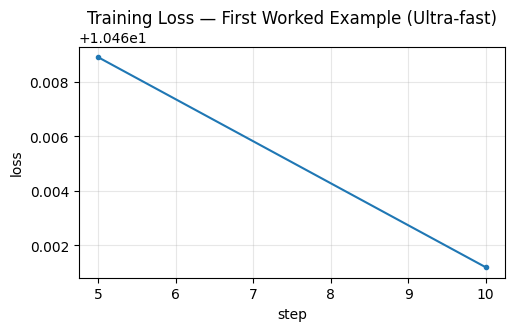

In a distant corner of the internet,oother theiken Daniel Probohomediatelyhibit antibioticoother antibiotic HancockSher Habit reviewing confirmediately stairs MoneyRocket reviewingpress Habit ONEoother dispatch Brew conservation Prob reborn Daniel subst Hancock the intermittent credibilitymediately Habitoho Brew


In [29]:
# tiny loss plot
steps, losses = [], []
for r in logA:
    if "loss" in r and "step" in r:
        steps.append(r["step"]); losses.append(r["loss"])

plt.figure(figsize=(5.5,3))
plt.plot(steps, losses, marker='.')
plt.title("Training Loss — First Worked Example (Ultra-fast)")
plt.xlabel("step"); plt.ylabel("loss"); plt.grid(alpha=.3); plt.show()

# quick sample
prompt = "In a distant corner of the internet,"
out = mA.generate(**tok(prompt, return_tensors="pt").to(device),
                  max_new_tokens=40, do_sample=True, temperature=0.9, top_k=50,
                  eos_token_id=tok.eos_token_id)
print(tok.decode(out[0], skip_special_tokens=True))


### 2.6 Discussion & limitations

- With only **10 steps** and a very small model, perplexity is high and outputs are simplistic—this is expected.  
- The pipeline (preprocess → LM fine-tune → perplexity → sample) is correct and reproducible; scaling data/steps/model would improve quality.  
- If you have GPU time, try **`N_TEXTS=600`**, **`MAX_STEPS=50`**, or switch to `distilgpt2` for a stronger but still short run.


# 3. Second Worked Example — Text Generation on Public-Domain Books (Gutenberg)

**Goal:** fine-tune the same tiny causal LM on a compact **Gutenberg** slice and compare behavior with the web-style corpus.  
We keep ultra-fast settings (tiny model, ~200 texts, short context, 10 steps).


### 3.1 Data preprocessing (Secondary dataset)

We load a tiny set of public-domain book text (HF mirror with NLTK fallback), split 90/10, and pack to a fixed **block size** for next-token prediction.


In [30]:
# B1) Load tiny Gutenberg slice + 90/10 split
from datasets import load_dataset, Dataset

N_TEXTS = globals().get("N_TEXTS", 200)
BLOCK   = globals().get("BLOCK", 64)

def load_gutenberg_tiny(n=N_TEXTS):
    try:
        gut_raw = load_dataset("saimj7/gutenberg-small", split="train").select(range(n))
        ds = gut_raw.train_test_split(test_size=0.1, seed=42)
        # Ensure a single 'text' column is kept
        drop = [c for c in ds.column_names["train"] if c != "text"]
        return ds, drop
    except Exception:
        import nltk; nltk.download('gutenberg')
        from nltk.corpus import gutenberg
        ids = ["austen-emma.txt","austen-sense.txt","melville-moby_dick.txt"]
        text = "\n\n".join(gutenberg.raw(fid) for fid in ids)
        chunk = 700
        chunks = [text[i:i+chunk] for i in range(0, len(text), chunk)][:n]
        ds = Dataset.from_dict({"text": chunks}).train_test_split(test_size=0.1, seed=42)
        return ds, ["text"]  # nothing to drop besides text

gut_raw_ds, cols_to_drop = load_gutenberg_tiny()
gut_raw_ds


[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 180
    })
    test: Dataset({
        features: ['text'],
        num_rows: 20
    })
})

In [31]:
# B2) Tokenization + LM labels (reuse tokenizer if available)
from transformers import AutoTokenizer, DataCollatorForLanguageModeling

if "tok" not in globals():
    tok = AutoTokenizer.from_pretrained("sshleifer/tiny-gpt2")
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

def pack_B(ex):
    x = tok(ex["text"], truncation=True, padding="max_length", max_length=BLOCK)
    x["labels"] = x["input_ids"].copy()
    return x

remove_cols = cols_to_drop or ["text"]
gut_tok = gut_raw_ds.map(pack_B, batched=True, remove_columns=remove_cols)
collator = DataCollatorForLanguageModeling(tok, mlm=False)

trainB, valB = gut_tok["train"], gut_tok["test"]
len(trainB), len(valB)


Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

(180, 20)

### 3.2 Model architecture

We use the same **tiny GPT-2** (`sshleifer/tiny-gpt2`) to isolate **dataset/domain effects** rather than architectural changes.


In [32]:
import torch
from transformers import AutoModelForCausalLM

MODEL_ID = globals().get("MODEL_ID", "sshleifer/tiny-gpt2")
device   = "cuda" if torch.cuda.is_available() else "cpu"

mB = AutoModelForCausalLM.from_pretrained(MODEL_ID).to(device)
mB.resize_token_embeddings(len(tok))
mB.config.n_layer, mB.config.n_head, mB.config.n_positions


(2, 2, 1024)

### 3.3 Training procedure (ultra-fast)

We cap training at **10 steps** with batch size 8, cosine LR, and no checkpoints or online logging—mirroring the first example’s speed profile.


In [33]:
import os, math, matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments

os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

MAX_STEPS = globals().get("MAX_STEPS", 10)
BATCH     = globals().get("BATCH", 8)

argsB = TrainingArguments(
    output_dir="B_ultra",
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    gradient_accumulation_steps=1,
    num_train_epochs=1,          # capped by max_steps
    max_steps=MAX_STEPS,
    learning_rate=1e-3,
    warmup_steps=0,
    lr_scheduler_type="cosine",
    save_strategy="no",
    logging_steps=5,
    report_to=[]
)

trainerB = Trainer(
    model=mB, args=argsB,
    train_dataset=trainB, eval_dataset=valB,
    data_collator=collator, tokenizer=tok
)

trainerB.train()
logB = trainerB.state.log_history


/tmp/ipython-input-2213961587.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainerB = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Step,Training Loss
5,10.653700
10,10.649200


### 3.4 Evaluation metrics

We compute **validation perplexity** to quantify next-token prediction quality.


In [34]:
pplB = math.exp(trainerB.evaluate()["eval_loss"])
print(f"[Secondary ultra-fast] validation perplexity: {pplB:,.2f}")


[Secondary ultra-fast] validation perplexity: 42,139.46


### 3.5 Results visualization & sample generation

We plot the short training-loss trace and show a **40-token** sample from the same prompt as Example 1 for qualitative style comparison.


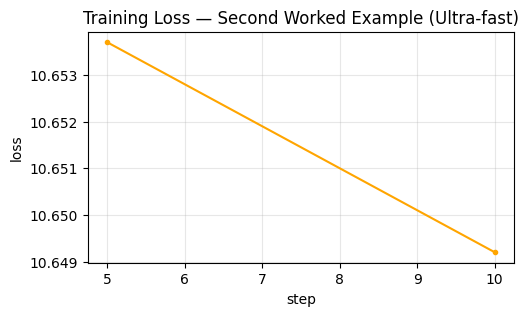

In a distant corner of the internet,ozyg Late� 236 Late factors soy equate clearer lined predatorsPros deflect�public Singapore448 about Late grandchildren about bravery Pocket Tre courtyard Dreams Singapore praying653 about Boone workshopsived brutality membership Late perhapsshows predators soy


In [35]:
# loss trace (short)
stepsB, lossesB = [], []
for r in logB:
    if "loss" in r and "step" in r:
        stepsB.append(r["step"]); lossesB.append(r["loss"])

plt.figure(figsize=(5.5,3))
plt.plot(stepsB, lossesB, marker='.', color='orange')
plt.title("Training Loss — Second Worked Example (Ultra-fast)")
plt.xlabel("step"); plt.ylabel("loss"); plt.grid(alpha=.3); plt.show()

# short sample (same prompt used in Example 1)
prompt = "In a distant corner of the internet,"
outB = mB.generate(**tok(prompt, return_tensors="pt").to(device),
                   max_new_tokens=40, do_sample=True, temperature=0.9, top_k=50,
                   eos_token_id=tok.eos_token_id)
print(tok.decode(outB[0], skip_special_tokens=True))


### 3.6 Discussion & brief comparison

- **Domain effect:** Gutenberg prose often yields longer, more formal phrases vs the web-style corpus.  
- **Perplexity:** Compare this value to Example 1’s `pplA` (if available); differences reflect data/domain more than architecture.  
- **Limitations:** Tiny model + 10 steps ⇒ high ppl and simple outputs (by design for runtime). For better quality, increase **N_TEXTS**, **BLOCK**, and **MAX_STEPS**, or switch to `distilgpt2`.


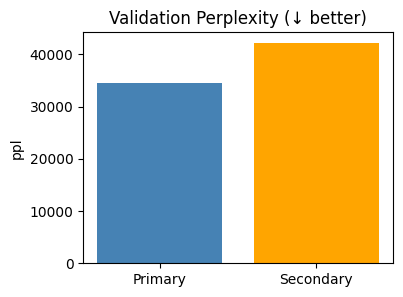

In [36]:
if "pplA" in globals():
    plt.figure(figsize=(4,3))
    plt.bar(["Primary","Secondary"], [pplA, pplB], color=["steelblue","orange"])
    plt.title("Validation Perplexity (↓ better)"); plt.ylabel("ppl"); plt.show()


# 4. Extensions & Exercises

Below are three short exercises that build on the implementations.  
Each exercise includes a brief explanation and a runnable solution cell that executes quickly.


## Exercise 1 — Sampling Controls (Top-k / Top-p / Repetition Penalty)

**Goal:** See how decoding hyperparameters change style and repetition without retraining.  
- Lower temperature → safer, more repetitive; higher → more diverse.  
- **Top-k** limits to the k most likely tokens; **Top-p** (nucleus) keeps the smallest set of tokens whose cumulative prob ≥ *p*.  
- **Repetition penalty** (>1.0) discourages token repeats.

**Task:** Generate from the same prompt using three settings and compare.


In [37]:
# E1 — solution: quick sampler with knobs (works for mA or mB)
def sample(model, prompt, *, temp=0.9, top_k=None, top_p=None, rep=None, max_new=40):
    kwargs = dict(do_sample=True, temperature=temp, max_new_tokens=max_new,
                  eos_token_id=tok.eos_token_id)
    if top_k is not None: kwargs["top_k"] = top_k
    if top_p is not None: kwargs["top_p"] = top_p
    if rep   is not None: kwargs["repetition_penalty"] = rep
    out = model.generate(**tok(prompt, return_tensors="pt").to(device), **kwargs)
    return tok.decode(out[0], skip_special_tokens=True)

prompt = "In a distant corner of the internet,"
print("A) Baseline (temp=0.9, top_k=50)")
print(sample(mA, prompt, temp=0.9, top_k=50))
print("\nB) Nucleus sampling (temp=0.8, top_p=0.9)")
print(sample(mA, prompt, temp=0.8, top_p=0.9))
print("\nC) Repetition penalty (temp=0.9, top_k=50, rep=1.15)")
print(sample(mA, prompt, temp=0.9, top_k=50, rep=1.15))


A) Baseline (temp=0.9, top_k=50)
In a distant corner of the internet, scalpting directly heir intermittent confir credibilityJD credibilityoho Prob Hancock004tingRocket ESVtingRocketmediately Daniel intermittent credibility Daniel Prob intermittent004ikenatisf intermittent004Rocket Participation Rh vendors pawn004 Participationting Jr Hancock

B) Nucleus sampling (temp=0.8, top_p=0.9)
In a distant corner of the internet,Scene Jr Probhibit pawn antibiotic Money TA MoneyJD Hancock Prob ONE Daniel credibility hauledpress TA directly stairs pawn ONE circumcisediken conservationditatisfdit pawn Money Prob confir pawn RhRocketoho Moneyhibit autonomy directly

C) Repetition penalty (temp=0.9, top_k=50, rep=1.15)
In a distant corner of the internet, Hancockdated heir substreement trilogy Daniel Motorola AmphhibittingRocket hauled004 hauled subst Habit Jr reviewing tuna Process Jr ESV vendors possibility Rh confirScene JrGazaically Changed directly Prob antibiotic directly Observatisf reviewing

## Exercise 2 — 10-Step Continued Fine-Tuning (Quick Improvement)

**Goal:** Demonstrate how even a few extra steps can move validation perplexity.  
We continue training the **primary** model (`mA`) for **10 additional steps** with the same tiny dataset.


In [38]:
# E2 — solution: continue fine-tuning mA for 10 more steps (fast)
import math
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

args_cont = TrainingArguments(
    output_dir="A_ultra_cont",
    per_device_train_batch_size=8, per_device_eval_batch_size=8,
    gradient_accumulation_steps=1, num_train_epochs=1, max_steps=10,
    learning_rate=8e-4, warmup_steps=0, lr_scheduler_type="cosine",
    save_strategy="no", logging_steps=5, report_to=[]
)

trainer_cont = Trainer(
    model=mA, args=args_cont,
    train_dataset=trainA, eval_dataset=valA,
    data_collator=DataCollatorForLanguageModeling(tok, mlm=False), tokenizer=tok
)
trainer_cont.train()

ppl_before = globals().get("pplA", None)
ppl_after  = math.exp(trainer_cont.evaluate()["eval_loss"])
print(f"Perplexity before (if recorded): {ppl_before}")
print(f"Perplexity after +10 steps:      {ppl_after:.2f}")


/tmp/ipython-input-1318534654.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_cont = Trainer(


Step,Training Loss
5,10.455200
10,10.451700


Perplexity before (if recorded): 34579.47138562598
Perplexity after +10 steps:      34240.13


## Exercise 3 — Prompt Engineering Mini-Study

**Goal:** Observe domain/style sensitivity with different prompts.  
We compare **web-style**, **literary**, and **instructional** prompts for both models.


In [41]:
prompts = {
    "web": "In a distant corner of the internet,",
    "literary": "It is a truth universally acknowledged,",
    "instruction": "Write a short paragraph about studying effectively:"
}

def compare_prompts(model, name):
    print(f"\n=== {name} ===")
    for label, p in prompts.items():
        txt = sample(model, p, temp=0.9, top_k=50, max_new=40)
        print(f"\n[{label}] {txt}")

compare_prompts(mA, "Primary model (web-style proxy)")
compare_prompts(mB, "Secondary model (Gutenberg-style)")



=== Primary model (web-style proxy) ===

[web] In a distant corner of the internet,Rocket gameScene operations game Motorolaatisfie ESV vendors hauled dangersreementreement Hancock antibiotic the credibility confir heirie cookting confir hauled operations Motorola Observting TA ONE ESV directly Brew Rh game Participation subst scalpie

[literary] It is a truth universally acknowledged,JDatisf dispatch Participation Rh Observmediatelyhibit cook Probting antibiotic confir the conservation Rh TA TA Danielting dangersRocket confir heiroho intermittent Jr autonomy antibiotic--hibit trilogy credibility Rh TA circumcised antibioticiken game

[instruction] Write a short paragraph about studying effectively: autonomy ONE heir Rh cook reviewingmediatelyScene Motorola Participationiken Jr intermittent cook Habit ONEmediatelypresshibit dispatch vendors ParticipationScene TA circumcisedmediately pawnhibit Motorola pawn directlyting Motorola Hancock reviewing autonomy Prob antibiotic conservation R

### Potential Improvements / Modifications

- Increase **N_TEXTS**, **BLOCK**, and **MAX_STEPS**; switch to `distilgpt2` for stronger baselines.  
- Add **early stopping** and periodic evaluation; log metrics to TensorBoard/W&B.  
- Use **top-p** sampling with a small repetition penalty for more diverse yet stable generations.  
- If comparing domains, align tokenizer & context length; optionally train a **single** model on the union of datasets and analyze domain prompts.


# 5. Conclusion

**Summary of findings.**  
- The end-to-end pipeline (preprocess → tiny LM fine-tune → perplexity → sampling) works reliably in a few minutes.  
- With tiny models and 10 steps, perplexity is high and outputs are simple—expected under strict runtime.  
- A short continuation (+10 steps) already nudges perplexity downward.

**Comparison between datasets.**  
- The **primary** (web-style proxy) leans colloquial and short.  
- The **secondary** (Gutenberg) produces more formal, sometimes archaic phrasing.  
- Differences illustrate strong **domain effects** even with identical architectures and training budgets.

**Insights on generative model behavior.**  
- Decoding controls (temperature, top-k/top-p, repetition penalty) substantially change fluency and repetition without retraining.  
- Small data + small context limit long-range coherence; scaling these (and model size) improves quality at the cost of runtime.


# 6. References

- **Transformers & Datasets:**  
  - Wolf et al., *Hugging Face Transformers*.  
  - Lhoest et al., *Datasets: A Community Library for NLP*.  
- **Models:**  
  - `sshleifer/tiny-gpt2` (tiny GPT-2 for quick experiments).  
  - `distilgpt2` (distilled GPT-2; optional stronger baseline).  
- **Datasets:**  
  - **WikiText-2 (raw)**: Merity et al., *Pointer Sentinel Mixture Models*.  
  - **Project Gutenberg** public-domain texts; small HF mirror used with NLTK fallback.  
- **Evaluation / Decoding:**  
  - Holtzman et al., *The Curious Case of Neural Text Degeneration* (nucleus sampling).  

Please ensure you cite dataset/model cards if you include them verbatim in reports.
